In [1]:
from data import *

folder_path = "Data/TestRecordings"
participant = "ALena"

rec = Recording(os.path.join(folder_path, participant))
rec.calc_events_all_conditions()

100%|██████████| 4/4 [00:18<00:00,  4.59s/it]


In [2]:
round_results = rec.summarize_rounds("nod")

In [3]:
rec["nod"]["SceneData"].Msg.unique()

array([nan, 'StartGame', 'Correct target selected',
       'Correct target selected | MainTargetDestroyed', 'EndGame',
       'Incorrect target selected',
       'Incorrect target selected | NonMaintargetDestroyed',
       'NonMaintargetDestroyed', 'MainTargetDestroyed'], dtype=object)

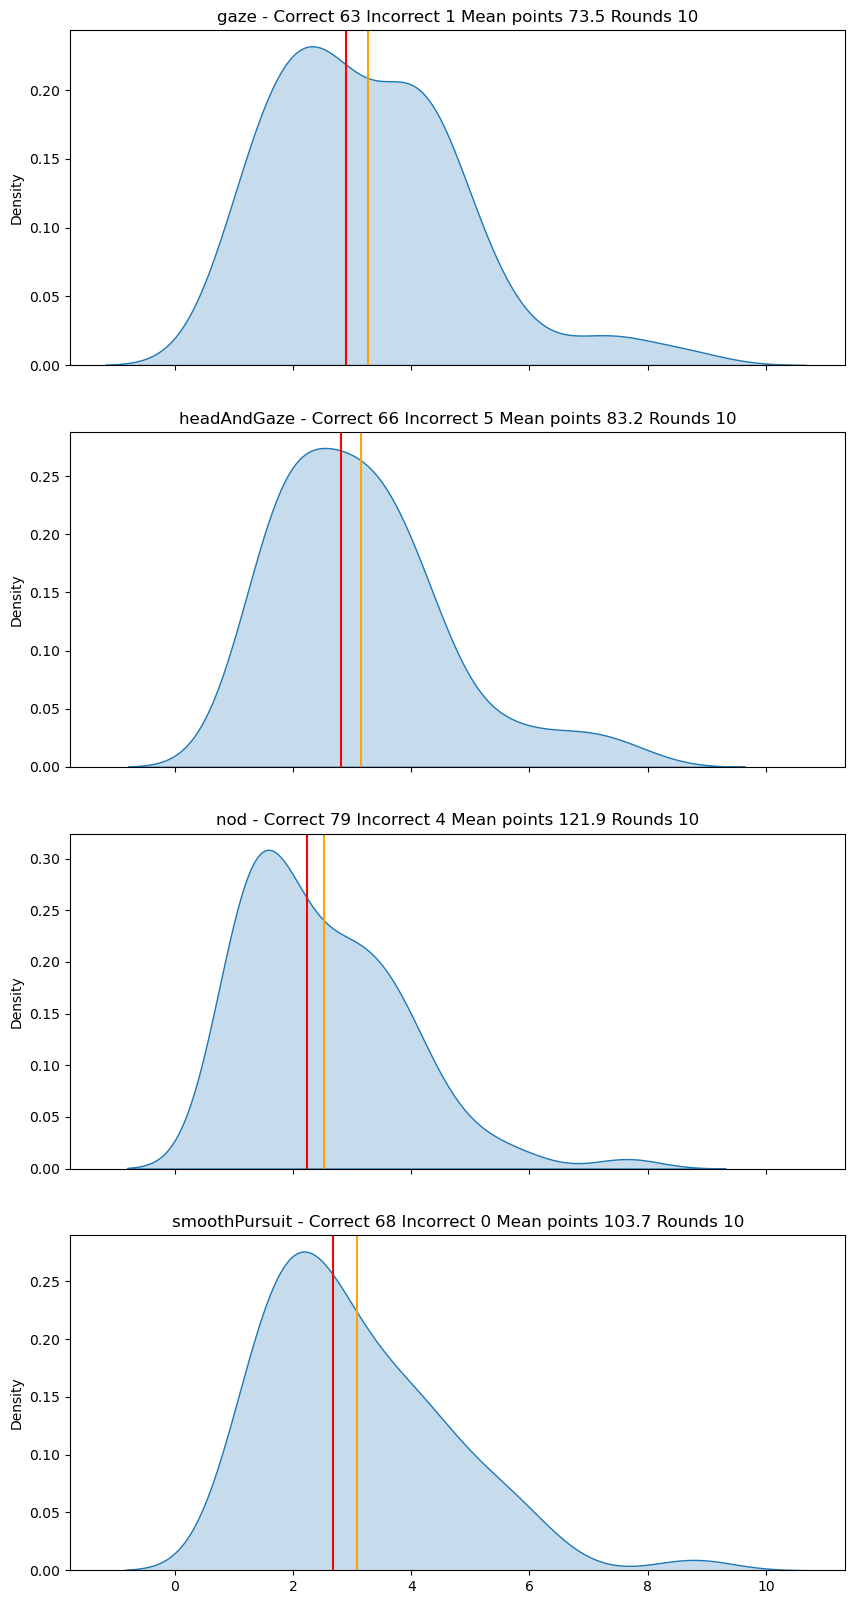

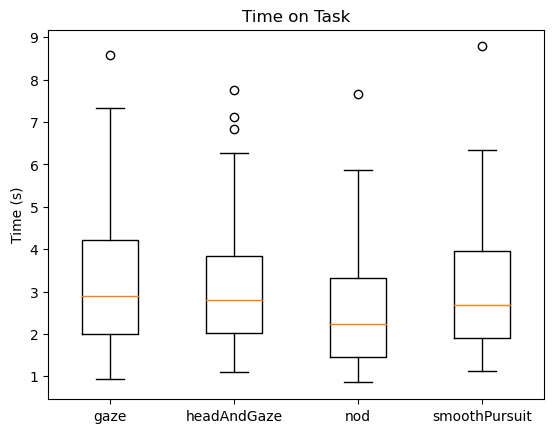

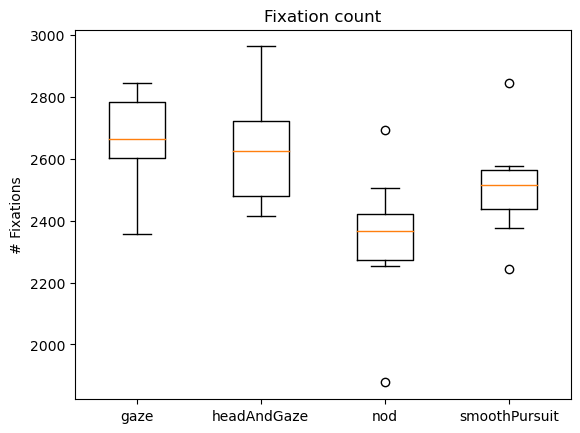

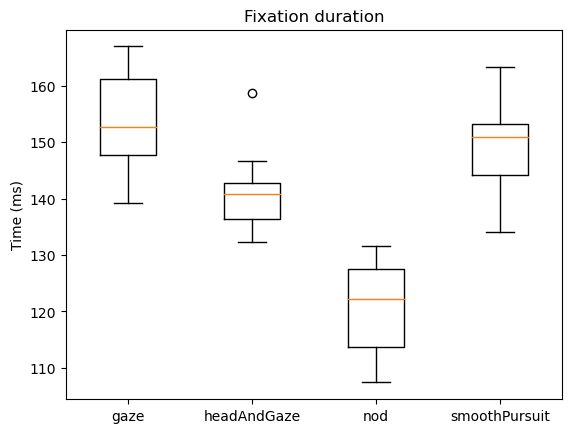

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(len(Recording.conditions), sharex=True, figsize=(10,20))
all_time_on_tasks = dict()
all_fixation_count = dict()
all_fixation_duration = dict()
for i, condition in enumerate(Recording.conditions):
    round_results = rec.summarize_rounds(condition)
    time_on_task = list()
    correct = 0
    incorrect = 0
    rounds_without_change = len(round_results)
    points = list()
    fixation_count = list()
    fixation_duration = list()
    for k in round_results:
        time_on_task += round_results[k]["TimeOnTask"]
        correct += round_results[k]["Correct"]
        incorrect += round_results[k]["Incorrect"]
        points.append(round_results[k]["Points"])
        fixation_count.append(round_results[k]["FixationCount"])
        fixation_duration.append(round_results[k]["MeanFixationDuration"])
    sns.kdeplot(time_on_task, fill=True, ax=axs[i])
    y_min, y_max = axs[i].get_ylim()
    axs[i].axvline(np.mean(time_on_task), 0, 1, color="orange")
    axs[i].axvline(np.median(time_on_task), 0, 1, color="red")
    axs[i].set_title(f"{condition} - Correct {correct} Incorrect {incorrect} Mean points {np.mean(points)} Rounds {rounds_without_change}")
    all_time_on_tasks[condition] = time_on_task
    all_fixation_count[condition] = fixation_count
    all_fixation_duration[condition] = fixation_duration
plt.show()

def create_boxplot(d, title, ylabel):
    _, ax = plt.subplots()
    ax.boxplot(d.values())
    ax.set_xticklabels(d.keys())
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.show()

create_boxplot(all_time_on_tasks, "Time on Task", "Time (s)")
create_boxplot(all_fixation_count, "Fixation count", "# Fixations")
create_boxplot(all_fixation_duration, "Fixation duration", "Time (ms)")

# fig, ax = plt.subplots()
# ax.boxplot(all_time_on_tasks.values())
# ax.set_xticklabels(all_time_on_tasks.keys())
# ax.set_ylabel("Time on selection (s)")
# ax.set_title("Time on Task")
# plt.show()



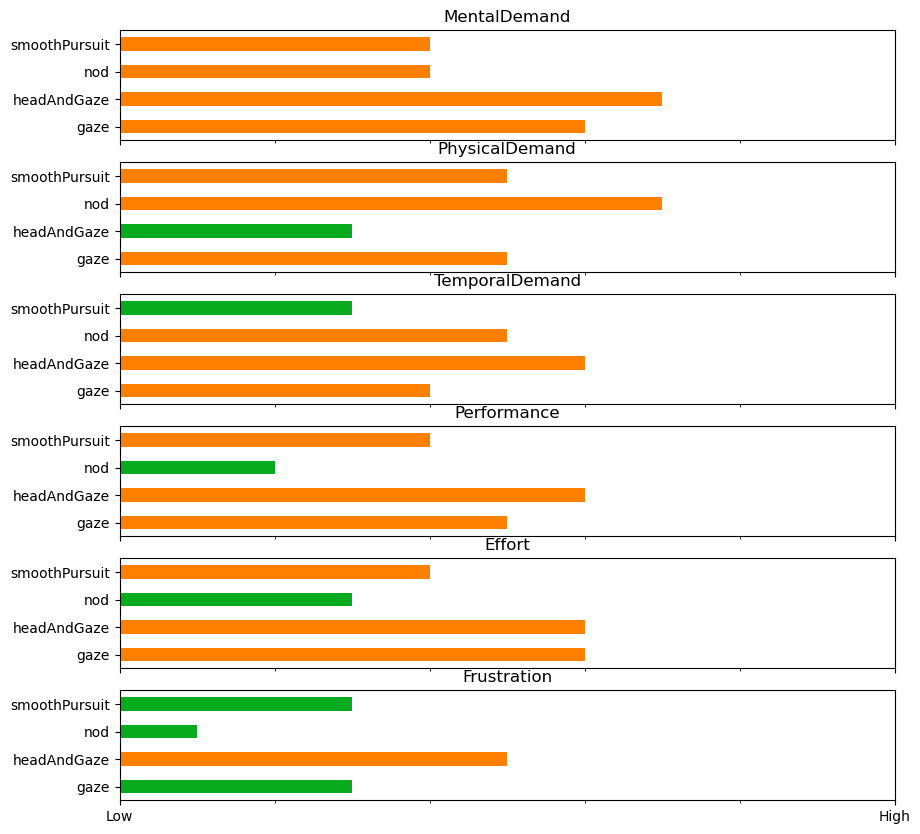

In [5]:
import matplotlib.pyplot as plt
import utils
_, axs = plt.subplots(len(rec["answers"]), sharex=True, sharey=True, figsize=(10, 10))
i = 0
for question, row in rec["answers"].iterrows():
    row.plot(
        kind="barh", 
        color = [utils.get_color(x) for x in row],
        title=question.replace("tlx_", ""), 
        ax=axs[i])
    axs[i].set_xticks([0, 100], ["Low", "High"])
    i += 1
plt.show()

In [6]:
scene_data = rec["nod"]["SceneData"]
scene_data.loc[scene_data.Msg.apply(lambda x: "Correct target selected" in str(x)), ["EyeDataTimestamp", "Msg"]]

,EyeDataTimestamp,Msg
5234,1723117340257,Correct target selected
5235,1723117340265,Correct target selected
5236,1723117340273,Correct target selected
5237,1723117340286,Correct target selected
5238,1723117340297,Correct target selected
...,...,...
54804,1723117890852,Correct target selected
54805,1723117890861,Correct target selected
54806,1723117890874,Correct target selected
54807,1723117890884,Correct target selected


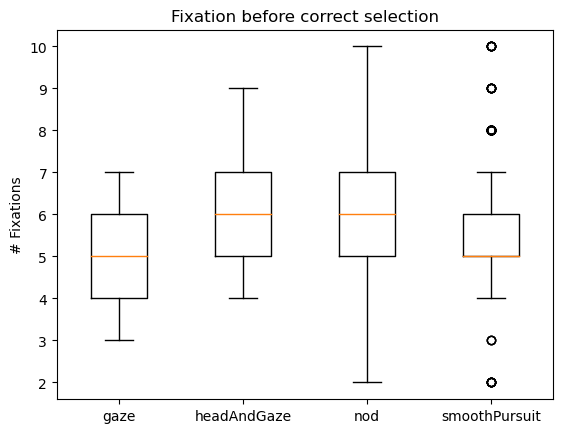

In [7]:
count_fixations = dict()
condition = "nod"
for condition in Recording.conditions:
    count_fixations[condition] = list()
    gaze120 = rec[condition]["Gaze120"]
    scene_data = rec[condition]["SceneData"]
    final_rounds = rec.get_final_rounds(condition)
    for _, row in final_rounds.iterrows():
        start, end = row[["StartDeviceTime", "EndDeviceTime"]]
        gaze_round = gaze120.loc[(gaze120["System Timestamp"] >= start) & (gaze120["System Timestamp"] <= end), ["System Timestamp", "Event"]]
        scene_data_round = scene_data.loc[(scene_data["EyeDataTimestamp"] >= start) & (scene_data["EyeDataTimestamp"] <= end), ["EyeDataTimestamp", "Msg"]]
        t_destroy = scene_data_round.loc[scene_data_round.Msg.apply(lambda x: "Correct target selected" in str(x)), "EyeDataTimestamp"].to_numpy()
        for t in t_destroy:
            fixations = gaze_round.loc[(gaze_round["System Timestamp"] < t) & (gaze_round["System Timestamp"] > t - 1000) & (gaze_round["Event"] != "Saccade"), "Event"].unique()
            count_fixations[condition].append(len(fixations))

create_boxplot(count_fixations, "Fixation before correct selection", "# Fixations")


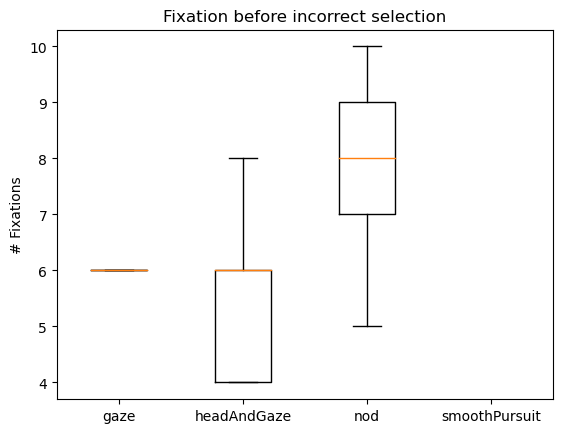

In [8]:
count_fixations = dict()
condition = "nod"
for condition in Recording.conditions:
    count_fixations[condition] = list()
    gaze120 = rec[condition]["Gaze120"]
    scene_data = rec[condition]["SceneData"]
    final_rounds = rec.get_final_rounds(condition)
    for _, row in final_rounds.iterrows():
        start, end = row[["StartDeviceTime", "EndDeviceTime"]]
        gaze_round = gaze120.loc[(gaze120["System Timestamp"] >= start) & (gaze120["System Timestamp"] <= end), ["System Timestamp", "Event"]]
        scene_data_round = scene_data.loc[(scene_data["EyeDataTimestamp"] >= start) & (scene_data["EyeDataTimestamp"] <= end), ["EyeDataTimestamp", "Msg"]]
        t_destroy = scene_data_round.loc[scene_data_round.Msg.apply(lambda x: "Incorrect target selected" in str(x)), "EyeDataTimestamp"].to_numpy()
        for t in t_destroy:
            fixations = gaze_round.loc[(gaze_round["System Timestamp"] < t) & (gaze_round["System Timestamp"] > t - 1000) & (gaze_round["Event"] != "Saccade"), "Event"].unique()
            count_fixations[condition].append(len(fixations))

create_boxplot(count_fixations, "Fixation before incorrect selection", "# Fixations")


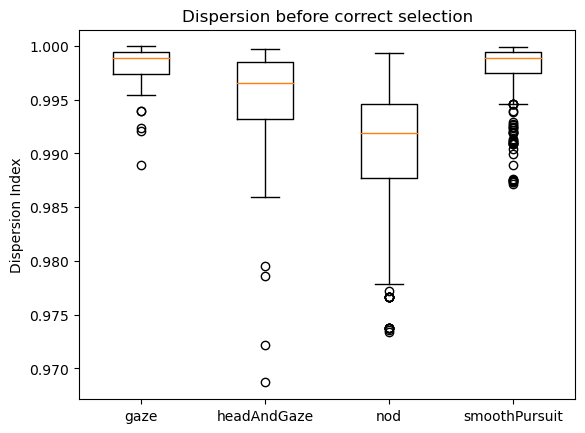

In [9]:
import utils
dispersion = dict()
time_window = 1000
condition = "nod"
errors = list()
for condition in Recording.conditions:
    dispersion[condition] = list()
    gaze120 = rec[condition]["Gaze120"]
    scene_data = rec[condition]["SceneData"]
    final_rounds = rec.get_final_rounds(condition)
    for _, row in final_rounds.iterrows():
        start, end = row[["StartDeviceTime", "EndDeviceTime"]]
        gaze_round = gaze120.loc[(gaze120["System Timestamp"] >= start) & (gaze120["System Timestamp"] <= end)]
        scene_data_round = scene_data.loc[(scene_data["EyeDataTimestamp"] >= start) & (scene_data["EyeDataTimestamp"] <= end), ["EyeDataTimestamp", "Msg"]]
        t_destroy = scene_data_round.loc[scene_data_round.Msg.apply(lambda x: "Correct target selected" in str(x)), "EyeDataTimestamp"].to_numpy()
        for t in t_destroy:
            gvs = gaze_round.loc[(gaze_round["System Timestamp"] < t) & (gaze_round["System Timestamp"] > t - time_window) & (gaze_round["Event"] != "Saccade"), ["Local Gaze Direction %s" % x for x in ["X", "Y", "Z"]]].to_numpy()
            disp = utils.calc_dispersion_index(gvs)
            dispersion[condition].append(disp)
            if disp > 1:
                errors.append(gvs)

create_boxplot(dispersion, "Dispersion before correct selection", "Dispersion Index")

In [10]:
errors

[]